# Implementing a bayesian normative model for cortical thickness using PYMC with ADVI

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

## Load aggregated data

---

In [5]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0)


## Fit a hierarchical bayesian model with PYMC + ADVI

---

Hierarchical Bayesian Regression (HBR) is capable of modeling site variations as a rendom stochastic effect with a prior distribution. In contrast to MCMC, ADVI ([Automatic Differentiation Variational Inference](https://docs.pymc.io/en/latest/api/generated/pymc.ADVI.html)) provides an approximate solution to the problem but is significantly faster and provides relatively accurate estimates.

The model below implements a nonlinear variation of thickness by age with intercepts that are influenced by site and sex. The model assumes a skewed normal distribution for thickness. Mean, variance, and skewness are all considered model variables that are fitted by observations. Mean and variance are considered to be affected by age, gender, and sex; whereas skewness is considered to be a fixed unknown variable.


In [8]:
%%time
# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness = sample_df['thickness'].values
thickness_standardized = (thickness - thickness.mean()) / thickness.std()
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

advi_model = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with advi_model:
    # minibatch variables
    age_standardized_t = pm.Minibatch(age_standardized, 100,)
    sex_idx_t = pm.Minibatch(sex_idxs, 100)
    site_idx_t = pm.Minibatch(site_idxs, 100)
    B_spline_age_t = pm.Minibatch(B_spline_age, 100)
    thickness_standardized_t = pm.Minibatch(thickness_standardized, 100)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
    sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
    sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

    # Priors    
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    
    # age splines
    w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated thickness
    thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))

    # Model error
    # nonlinear age error
    w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
    
    # constant sex error
    error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
    
    # random site error
    error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
    error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    
    # Error estimate
    thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    
    # Skewness estimate
    thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
    #thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
    
    # Likelihood (sampling distribution) of observations
    # need to figure out how to bound the distribution
#     pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
    thickness_like = pm.SkewNormal(
        "thickness_like",
        mu=thickness_est,
        sigma=thickness_error,
        alpha=thickness_skewness,
        observed=thickness_standardized_t,
        total_size=len(sample_df),
    )
    
    # run ADVI with minibatch
    error_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    
    # sample from trace
    advi_model_idata = pm.sample_prior_predictive()
    advi_model_idata.extend(error_approx.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata, extend_inferencedata=True)


Finished [100%]: Average Loss = 56.349
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, thickness_skewness, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


CPU times: user 3min 5s, sys: 951 ms, total: 3min 6s
Wall time: 4min 27s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


## Visualise fitted centiles

---

CPU times: user 4.32 s, sys: 1.84 s, total: 6.15 s
Wall time: 2.88 s


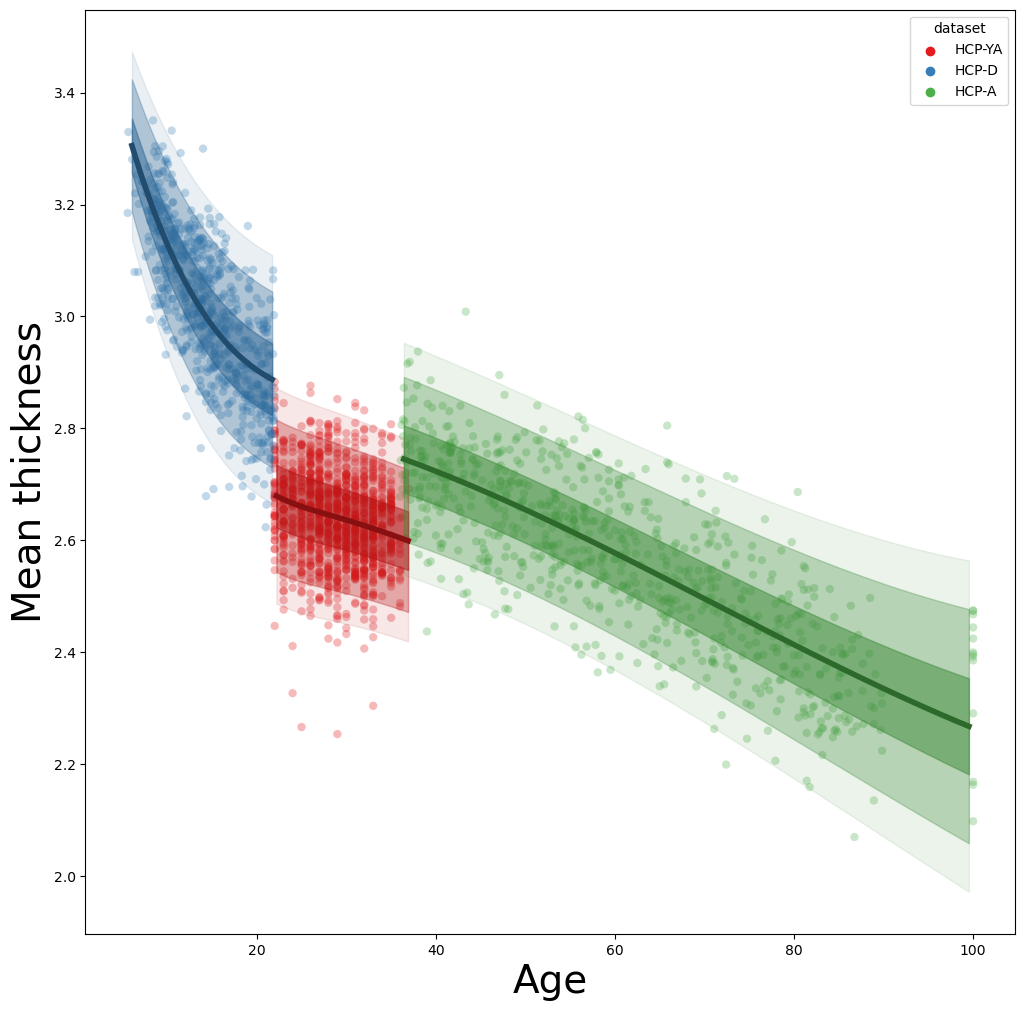

In [79]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_sigma = (
        post['error_sex'].stack(sample=("chain", "draw"))[0].data +
        post['error_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_error_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu.mean(1) + stats.skewnorm.ppf(q=q, a=y_ppc_alpha.mean()) * y_ppc_sigma.mean(1)
            )  * thickness.std() +
            thickness.mean()
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


## Store the inference data

---

In [16]:
advi_model_idata.to_netcdf(ensure_dir(f'{main_dir}/data/models/pymc/mean_thickness_advi.nc'))


'/mountpoint/code/projects/normative_brain_charts/data/models/pymc/mean_thickness_advi.nc'

In [ ]:
# advi_model_idata.to_zarr(ensure_dir(f'{main_dir}/data/models/pymc/mean_thickness_advi.zarr'))


## Alternative fit with PYMC + ADVI

---

The model below implements a nonlinear variation of thickness by age with intercepts that are influenced by site and sex. The model assumes a skewed normal distribution for thickness. Mean, variance, and skewness are all considered model variables that are fitted by observations. Mean and variance are considered to be affected by age, gender, and sex; whereas **skewness is considered to smoothly varry by age**.


In [80]:
%%time
# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness = sample_df['thickness'].values
thickness_standardized = (thickness - thickness.mean()) / thickness.std()
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

scratch_advi_model = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with scratch_advi_model:
    # minibatch variables
    age_standardized_t = pm.Minibatch(age_standardized, 100,)
    sex_idx_t = pm.Minibatch(sex_idxs, 100)
    site_idx_t = pm.Minibatch(site_idxs, 100)
    B_spline_age_t = pm.Minibatch(B_spline_age, 100)
    thickness_standardized_t = pm.Minibatch(thickness_standardized, 100)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
    sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
    sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

    # Priors    
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    
    # age splines
    w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated thickness
    thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))

    # Model error
    # nonlinear age error
    w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
    
    # constant sex error
    error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
    
    # random site error
    error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
    error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    
    # Error estimate
    thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    
    # Skewness estimate
    # nonlinear age varying skewness
    w_skewness_age = pm.Normal("w_skewness_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    thickness_skewness = pm.Deterministic("thickness_skewness", pm.math.dot(B_spline_age_t, w_skewness_age.T))
    
    # Likelihood (sampling distribution) of observations
    # need to figure out how to bound the distribution
#     pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
    thickness_like = pm.SkewNormal(
        "thickness_like",
        mu=thickness_est,
        sigma=thickness_error,
        alpha=thickness_skewness,
        observed=thickness_standardized_t,
        total_size=len(sample_df),
    )
    
    # run ADVI with minibatch
    scratch_error_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    
    # sample from trace
    scratch_advi_model_idata = pm.sample_prior_predictive()
    scratch_advi_model_idata.extend(scratch_error_approx.sample(2000))
    pm.sample_posterior_predictive(scratch_advi_model_idata, extend_inferencedata=True)


Finished [100%]: Average Loss = 56.545
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age, w_skewness_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


CPU times: user 3min 8s, sys: 756 ms, total: 3min 9s
Wall time: 3min 12s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


## Visualise fitted centiles

---

CPU times: user 8min 29s, sys: 2.97 s, total: 8min 32s
Wall time: 8min 28s


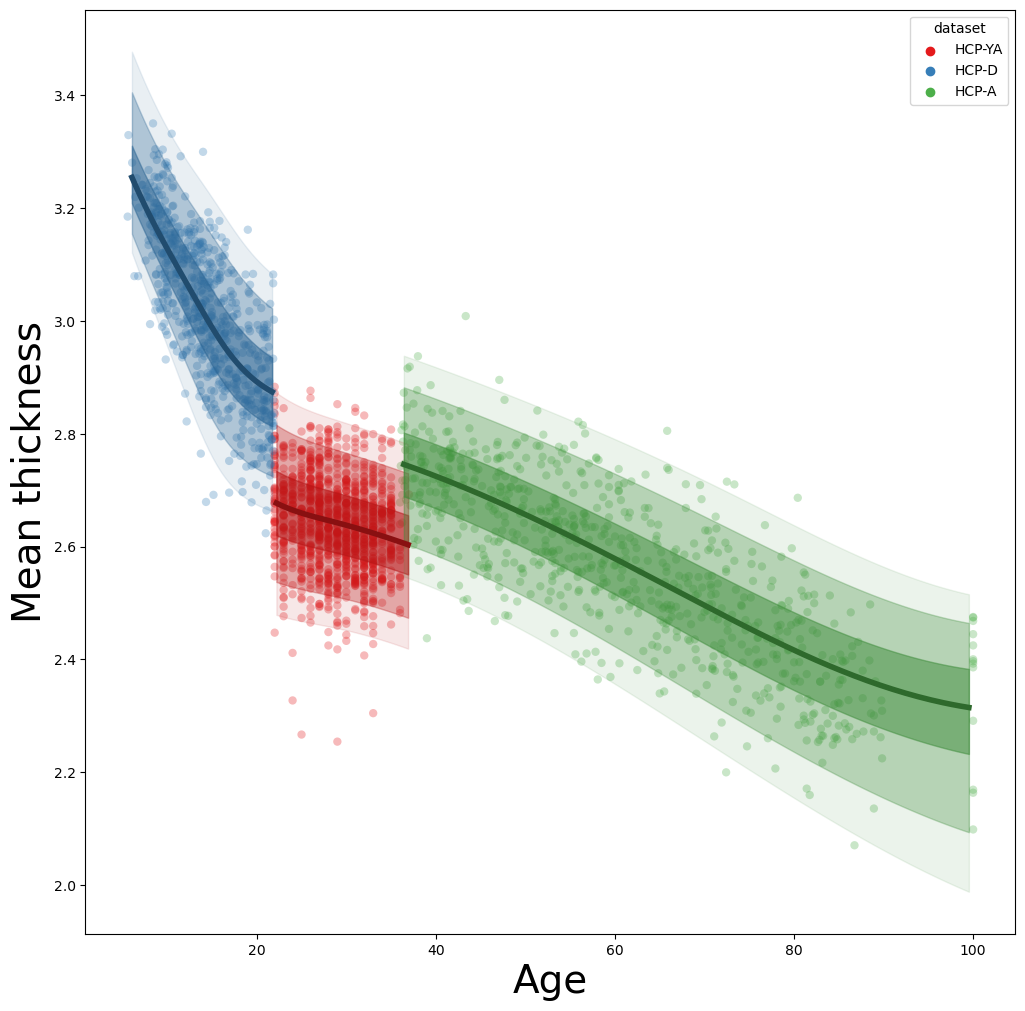

In [93]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = scratch_advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_sigma = (
        post['error_sex'].stack(sample=("chain", "draw"))[0].data +
        post['error_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_error_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_alpha = np.dot(
        prediction_B_spline_age,
        post['w_skewness_age'].stack(sample=("chain", "draw"))
    )
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu.mean(1) + stats.skewnorm.ppf(q=q, a=y_ppc_alpha.mean(1)) * y_ppc_sigma.mean(1)
            )  * thickness.std() +
            thickness.mean()
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


## Store the inference data

---

In [94]:
scratch_advi_model_idata.to_netcdf(ensure_dir(f'{main_dir}/data/models/pymc/mean_thickness_advi_varying_skewness.nc'))


'/mountpoint/code/projects/normative_brain_charts/data/models/pymc/mean_thickness_advi_varying_skewness.nc'